### Import Dataset and Organize the Dataframe

In [6]:
# Let's import the necessary libraries
import pandas as pd

# Read in the dataset 
df = pd.read_csv('wgm_full_wave2_public_file_final_csv.csv',na_values=" ", keep_default_na=False,low_memory=False)

# Organizing the dataset:

# DEMOGRAPHIC INFORMATION
# Copy the original dataframe and select the columns associated with demograph information. 
#  These demographic factors are categorical variables; convert the datatype to 'categorical'
demographicInfo = df.copy()[['Global11Regions','Gender', 'Age','age_var3',
                             'Education','Household_Income','wbi',
                             'Subjective_Income','EMP_2010']].astype('category')

# First we add a new level/category of '99.0' to the feature:
demographicInfo['Household_Income'] = demographicInfo['Household_Income'].cat.add_categories(99.0)
demographicInfo['EMP_2010'] = demographicInfo['EMP_2010'].cat.add_categories(99.0)

# Impute the NaN values with '99.0' ('Don't Know/Refused')
demographicInfo['Household_Income'].fillna(99.0, inplace=True)
demographicInfo['EMP_2010'].fillna(99.0, inplace=True)


# QUESTIONNAIRE DATA
# Perception of science:
sciPercep = df.copy().iloc[:,6:28].astype('category')
sciPercep['W3'] = sciPercep['W3'].cat.add_categories(99.0) # Add a new level to 'W3'
sciPercep['W3'].fillna(99.0, inplace=True) # Impute the NaN values with the new level

# Impute the NaN entries with the values stated above
sciPercep['W4'].fillna(99.0, inplace=True)
sciPercep['W5B'].fillna(99.0, inplace=True)
sciPercep['W5D'].fillna(99.0, inplace=True)
sciPercep['W7C'].fillna(99.0, inplace=True)


# Perceptions about Climate Change
climateChange = df.copy().iloc[:,28:31].astype('category')
# Impute the NaN entries with the values stated above
climateChange['W14'].fillna(99.0, inplace=True)
climateChange['W15'].fillna(99.0, inplace=True)


# Perceptions of science with respect to COVID-19 pandemic
covidPercep = df.copy().iloc[:,31:38].astype('category')
# Impute the NaN entries with the values stated above
covidPercep['W15_1A'].fillna(99.0, inplace=True)
covidPercep['W15_1B'].fillna(99.0, inplace=True)
covidPercep['W15_1C'].fillna(99.0, inplace=True)
covidPercep['W15_1D'].fillna(99.0, inplace=True)
covidPercep['W15_1E'].fillna(99.0, inplace=True)
covidPercep['W15_2A'].fillna(99.0, inplace=True)
covidPercep['W15_2B'].fillna(99.0, inplace=True)


# Perceptions about physical and mental health:
sciHealth = df.copy().iloc[:,38:67].astype('category')
# Impute the NaN entries with the values stated above for MH3A to MH5 + MH7A
sciHealth['MH3A'].fillna(99.0, inplace=True)
sciHealth['MH3B'].fillna(99.0, inplace=True)
sciHealth['MH3C'].fillna(99.0, inplace=True)
sciHealth['MH3D'].fillna(99.0, inplace=True)
sciHealth['MH4A'].fillna(99.0, inplace=True)
sciHealth['MH4B'].fillna(99.0, inplace=True)
sciHealth['MH5'].fillna(99.0, inplace=True)
sciHealth['MH7A'].fillna(99.0, inplace=True)
# Impute the NaN entries with the values stated above for MH1 and MH6
sciHealth['MH1'].fillna(99, inplace=True)
sciHealth['MH6'].fillna(99, inplace=True)


# Social Media Usage
socialMedia = df.copy().iloc[:,67:70].astype('category')
# Impute the NaN values
socialMedia['W28'].fillna(99.0, inplace=True)
socialMedia['W29'].fillna(99.0, inplace=True)


# Religion
religion = df.copy()['W30'].astype('category')

# Impute missing values
religion.fillna(99.0, inplace=True)

Generating the final dataset used for Classification

In [7]:
questionDataset = pd.concat([sciPercep, climateChange, covidPercep,sciHealth.iloc[:,0:10], socialMedia, religion.to_frame()],axis=1)
# Remove 'Age' and keep 'age_var3'
demographicInfo = demographicInfo.drop('Age',axis=1)

dataset = pd.concat([demographicInfo, questionDataset],axis=1)
dataset.shape # 119 088 entries and 54 columns/features

(119088, 54)

In [8]:
dataset = dataset[(dataset['MH7A'] == 1.0) | (dataset['MH7A'] == 2.0)]
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116810 entries, 0 to 119087
Data columns (total 54 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   Global11Regions    116810 non-null  category
 1   Gender             116810 non-null  category
 2   age_var3           116810 non-null  category
 3   Education          116810 non-null  category
 4   Household_Income   116810 non-null  category
 5   wbi                116810 non-null  category
 6   Subjective_Income  116810 non-null  category
 7   EMP_2010           116810 non-null  category
 8   W1                 116810 non-null  category
 9   W2                 116810 non-null  category
 10  W3                 116810 non-null  category
 11  W4                 116810 non-null  category
 12  W5A                116810 non-null  category
 13  W5B                116810 non-null  category
 14  W5C                116810 non-null  category
 15  W5D                116810 non-null

### Classification

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

Splitting the dataset into features and target/label:

In [9]:
y = dataset['MH7A'] # The label: MH7A 
y.shape # 119 088 entries

(116810,)

In [10]:
X = dataset.drop(columns='MH7A') # The independent variables/features used for classification
X.shape # 119 088 entries and 54 columns/features

(116810, 53)

Split the dataset into training/testing sets using a 70/30 split:

In [13]:
# 70% training and 30% test sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=1)

In [48]:
X_train.shape

(81767, 53)

In [49]:
X_test.shape

(35043, 53)

#### Baseline Classifier using Decision Tree
- gini impurity measure
- using all 53 features

In [19]:
# Create Decision Tree Classifier object
clfDT = tree.DecisionTreeClassifier()

# Fit the model
clfDT.fit(X_train, y_train)

# Predicting labels for the Test Set
y_pred = clfDT.predict(X_test)

print(confusion_matrix(y_test, y_pred))

# TN, FP
# FN, TP
## y_pred: Predicted labels
## y_test: True Labels

[[ 2581  4599]
 [ 5331 22532]]


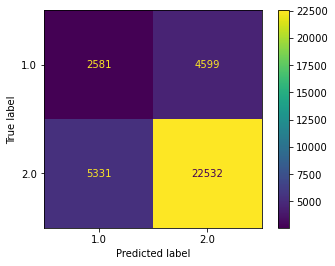

In [20]:
cm = confusion_matrix(y_test, y_pred, labels=clfDT.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clfDT.classes_)
disp.plot()
plt.show()

In [21]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))

Accuracy: 0.7166338498416231
Precision: 0.3262133468149646
Recall: 0.3594707520891365
F1 Score: 0.34203551550490324


##### Feature Selection using Chi-Squared Test

In [23]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

Feature 0: 895.456901
Feature 1: 16.520788
Feature 2: 429.357539
Feature 3: 206.765457
Feature 4: 846.724313
Feature 5: 39.561801
Feature 6: 711.372076
Feature 7: 59.517958
Feature 8: 78.933518
Feature 9: 264.673228
Feature 10: 802.682457
Feature 11: 839.676847
Feature 12: 149.290457
Feature 13: 3299.105630
Feature 14: 18.832843
Feature 15: 8.387719
Feature 16: 13.242311
Feature 17: 1258.828622
Feature 18: 830.888446
Feature 19: 97.691066
Feature 20: 767.574079
Feature 21: 1735.630512
Feature 22: 1669.939171
Feature 23: 383.940229
Feature 24: 974.274333
Feature 25: 1157.068725
Feature 26: 2035.334654
Feature 27: 1943.582749
Feature 28: 246.275184
Feature 29: 3425.815844
Feature 30: 429.198579
Feature 31: 852.821591
Feature 32: 1377.413362
Feature 33: 11101.115091
Feature 34: 14531.825730
Feature 35: 15976.569347
Feature 36: 14023.354942
Feature 37: 12520.446012
Feature 38: 9385.945667
Feature 39: 9706.794076
Feature 40: 133.277412
Feature 41: 1182.391846
Feature 42: 10621.389196
Featur

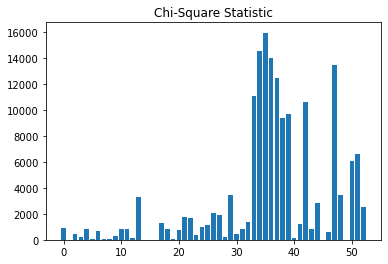

In [59]:
# # Using the Chi-Squared test to identify features that are NOT independent of the target variable/label
fs = SelectKBest(score_func=chi2, k='all')
fs.fit(X_train, y_train)
X_train_fs = fs.transform(X_train)
X_test_fs = fs.transform(X_test)

# what are scores for the features
for i in range(len(fs.scores_)):
 print('Feature %d: %f' % (i, fs.scores_[i]))
# plot the scores
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.title('Chi-Square Statistic')
plt.show()

Based on the scores shown above, let's set a threshold of 2000. Any features that have a score greater than 2000 will be included as a feature in future models.

In [29]:
selector = SelectKBest(score_func=chi2, k=17)
selector.fit(X_train, y_train)
# Get columns to keep and create new dataframe with those only
cols_idxs = selector.get_support(indices=True)
X_fs = X_train.iloc[:,cols_idxs]

In [30]:
X_fs

,W5B,W11A,MH2B,W15_1A,W15_1B,W15_1C,W15_1D,W15_1E,W15_2A,W15_2B,MH3B,MH3D,MH5,MH6,W28,W29,W30
43560,2.0,1,2,2.0,2.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,3.0,99,99.0,99.0,1.0
62908,4.0,1,99,4.0,3.0,1.0,1.0,99.0,3.0,1.0,3.0,99.0,1.0,2,3.0,3.0,3.0
34789,2.0,1,2,2.0,2.0,2.0,1.0,2.0,2.0,2.0,1.0,2.0,2.0,2,99.0,99.0,2.0
55266,1.0,2,1,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1,1.0,1.0,1.0
75584,99.0,1,3,1.0,2.0,1.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0,2,3.0,3.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50736,1.0,3,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2,3.0,3.0,4.0
99189,99.0,1,4,99.0,1.0,2.0,2.0,99.0,1.0,1.0,2.0,3.0,1.0,1,1.0,2.0,1.0
5214,3.0,1,1,3.0,1.0,2.0,2.0,2.0,1.0,1.0,2.0,1.0,2.0,1,3.0,2.0,2.0
78640,3.0,1,3,2.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0,3.0,2,2.0,3.0,1.0


In [39]:
# Let's add the demographic features into X_fs:
X_train_fs = pd.concat([X_train.iloc[:,0:8], X_fs],axis=1)
X_train_fs

,Global11Regions,Gender,age_var3,Education,Household_Income,wbi,Subjective_Income,EMP_2010,W5B,W11A,...,W15_1E,W15_2A,W15_2B,MH3B,MH3D,MH5,MH6,W28,W29,W30
43560,11,2,2,2,5.0,3,3,5.0,2.0,1,...,1.0,1.0,2.0,1.0,1.0,3.0,99,99.0,99.0,1.0
62908,2,1,3,2,1.0,2,4,1.0,4.0,1,...,99.0,3.0,1.0,3.0,99.0,1.0,2,3.0,3.0,3.0
34789,8,2,3,2,1.0,3,4,6.0,2.0,1,...,2.0,2.0,2.0,1.0,2.0,2.0,2,99.0,99.0,2.0
55266,11,2,3,2,1.0,1,3,5.0,1.0,2,...,1.0,2.0,1.0,1.0,1.0,1.0,1,1.0,1.0,1.0
75584,10,2,3,3,5.0,4,2,1.0,99.0,1,...,1.0,1.0,3.0,1.0,1.0,1.0,2,3.0,3.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50736,6,2,2,2,4.0,2,3,2.0,1.0,3,...,1.0,1.0,1.0,1.0,2.0,2.0,2,3.0,3.0,4.0
99189,11,1,1,2,1.0,4,2,6.0,99.0,1,...,99.0,1.0,1.0,2.0,3.0,1.0,1,1.0,2.0,1.0
5214,10,2,3,2,2.0,3,4,5.0,3.0,1,...,2.0,1.0,1.0,2.0,1.0,2.0,1,3.0,2.0,2.0
78640,2,2,1,2,5.0,3,1,4.0,3.0,1,...,3.0,3.0,2.0,3.0,1.0,3.0,2,2.0,3.0,1.0


#### Classification using smaller Feature Set

In [41]:
X_train_fs.info() # 25 features now being used

<class 'pandas.core.frame.DataFrame'>
Int64Index: 81767 entries, 43560 to 99685
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   Global11Regions    81767 non-null  category
 1   Gender             81767 non-null  category
 2   age_var3           81767 non-null  category
 3   Education          81767 non-null  category
 4   Household_Income   81767 non-null  category
 5   wbi                81767 non-null  category
 6   Subjective_Income  81767 non-null  category
 7   EMP_2010           81767 non-null  category
 8   W5B                81767 non-null  category
 9   W11A               81767 non-null  category
 10  MH2B               81767 non-null  category
 11  W15_1A             81767 non-null  category
 12  W15_1B             81767 non-null  category
 13  W15_1C             81767 non-null  category
 14  W15_1D             81767 non-null  category
 15  W15_1E             81767 non-null  category
 16  

##### Using the baseline classifier (Decision Tree)

First let's update X_test with the new features:

In [50]:
# Get columns to keep and create new dataframe with those only
cols_idxs = selector.get_support(indices=True)
X_test_fs = X_test.iloc[:,cols_idxs]

# The testing set to be used
X_test_fs = pd.concat([X_test.iloc[:,0:8],X_test_fs],axis=1)

In [52]:
X_test_fs.shape

(35043, 25)

In [53]:
# Create Decision Tree Classifier object
clfDT_fs = tree.DecisionTreeClassifier()

# Fit the model
clfDT_fs.fit(X_train_fs, y_train)

# Predicting labels for the Test Set
y_pred_fs = clfDT_fs.predict(X_test_fs)

print(confusion_matrix(y_test, y_pred_fs))

# TN, FP
# FN, TP
## y_pred: Predicted labels
## y_test: True Labels

[[ 2554  4626]
 [ 5408 22455]]


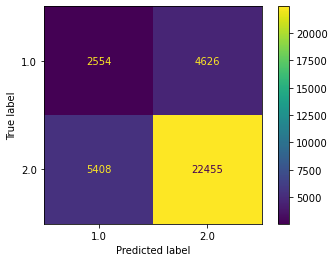

In [54]:
cm = confusion_matrix(y_test, y_pred_fs, labels=clfDT_fs.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clfDT_fs.classes_)
disp.plot()
plt.show()

In [56]:
print("Accuracy:", accuracy_score(y_test, y_pred_fs))
print("Precision:", precision_score(y_test, y_pred_fs))
print("Recall:", recall_score(y_test, y_pred_fs))
print("F1 Score:", f1_score(y_test, y_pred_fs))

Accuracy: 0.7136660674029051
Precision: 0.3207736749560412
Recall: 0.3557103064066852
F1 Score: 0.3373398494254392
